# Data downloaden van api.data.amsterdam.nl

Er zijn veel openbare datasets te vinden over de stad Amsterdam en een aantal kan je ophalen via een API van de gemeente. Als je in een browser navigeert naar *https://api.data.amsterdam.nl* zie je het beschikbare aanbod.

In dit tech report laten we zien hoe je alle evenementen in Amsterdam kan ophalen. Als je dit notebook wil downloaden om er zelf mee verder te werken: rechterklik op 'Raw'-knopje bovenaan en kies dan 'Link opslaan als'.

In [13]:
#import packages
import pandas as pd
import numpy as np
import requests
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt

Uit de API pagina genoemd in de inleiding zien we dat het API adres van de evenementen *https://api.data.amsterdam.nl/v1/evenementen/evenementen/* is. We kunnen de inhoud hiervan opvragen met een GET request (hetzelfde als wat een browser doet, je kan het dus ook testen door de url in een nieuw tabblad te plakken). 

Om gebruik te maken van de API van de gemeente Amsterdam moet je een gratis api-key aanvragen. Dat kan via de pagina [U kunt met dit formulier een API key aanvragen](https://keys.api.data.amsterdam.nl/clients/v1/register/). De code die je ontvangt kan je in de volgende stap invullen zodat de rest van het voorbeeld werkt. 

In [ ]:
api_key = input()
header = {'X-Api-Key' : api_key}

In python gebruiken we de **get()** functie uit het requests package en met de **.json()** methode wordt de inhoud van de response omgezet naar een python dictionary. We bekijken enkele keys uit de dictionary: 

In [4]:
response = requests.get('https://api.data.amsterdam.nl/v1/evenementen/evenementen/', headers = header).json()
response['_links']

{'self': {'href': 'https://api.data.amsterdam.nl/v1/evenementen/evenementen/'},
 'next': {'href': 'https://api.data.amsterdam.nl/v1/evenementen/evenementen/?page=2'}}

In [5]:
response['page']

{'number': 1, 'size': 20}

In [6]:
response['_embedded']['evenementen'][0]

{'_links': {'schema': 'https://schemas.data.amsterdam.nl/datasets/evenementen/dataset#evenementen',
  'self': {'href': 'https://api.data.amsterdam.nl/v1/evenementen/evenementen/1/',
   'title': 'Ter ere van het 10-jarig bestaan van stichting Amsterdam Street Art (ASA) stonden er in 2020 verschillende spraakmakende activiteiten gepland. Vanwege de maatregelen konden deze activiteiten helaas niet plaatsvinden maar verheugd kunnen wij jullie vertellen dat één van die geplande hoogtepunten nu wel plaats gaat vinden.\r\nOnbedoeld maar geheel passend bij de huidige “problematiek” zal op 24 september onze expositie Naar de Gallemiezen, an Amsterdam Love story starten.\r\n\r\nTijdens deze unieke expositie brengen wij vanuit alle kunstdisciplines de uitersten bij elkaar. Een unieke mengelmoes van gepassioneerde rebellie, doordachte filosofieën, samenwerkingen en samenzweringen, maar ook de originele en karakteristieke liefdesverklaringen voor en over onze stad Amsterdam.\r\n\r\nToepasselijke be

Hierin zien we dat we in eerste instantie 20 resultaten krijgen. De resultaten zijn dus gepagineerd (de volgende 20 staan op page 2), we zullen dus een loop moeten schrijven om alles op te halen. Eerst schrijven een functie die een enkele pagina opvraagt en de resultaten één voor één naar een pandas DataFrame omzet (dit moet één voor één omdat de structuur niet tabelvormig is, de waarde bij key 'geometry' is bijv zelf weer een dictionary).

In [7]:
def get_page(url):
    call = requests.get(url).json()
    try:
        next_page = call['_links']['next']['href']
    except:
        next_page = None
    df = pd.concat([pd.DataFrame([call['_embedded']['evenementen'][i]]) for i in range(len(call['_embedded']['evenementen']))])
    return df, next_page

In [8]:
get_page('https://api.data.amsterdam.nl/v1/evenementen/evenementen/')[0].head()

,_links,id,geometry,titel,omschrijving,startdatum,einddatum,starttijd,eindtijd,url
0,{'schema': 'https://schemas.data.amsterdam.nl/...,1,"{'type': 'Point', 'coordinates': [121632.00006...","Naar de Gallemiezen, an Amsterdam Love story",Ter ere van het 10-jarig bestaan van stichting...,2021-09-24,2021-09-24,None,None,https://evenementen.amsterdam.nl/evenementen/2...
0,{'schema': 'https://schemas.data.amsterdam.nl/...,2,"{'type': 'Point', 'coordinates': [122419.00006...",Tentoonstelling: Luther & Oranje,De geschiedenis van Het Huis van Oranje-Nassau...,2021-10-07,2021-10-07,None,None,https://evenementen.amsterdam.nl/evenementen/2...
0,{'schema': 'https://schemas.data.amsterdam.nl/...,3,"{'type': 'Point', 'coordinates': [124455.00006...",Expositie: Gewoon Anders,Kinderen van Het BuurtAtelier laten hun ideeën...,2021-10-15,2021-10-15,None,None,https://evenementen.amsterdam.nl/evenementen/2...
0,{'schema': 'https://schemas.data.amsterdam.nl/...,4,"{'type': 'Point', 'coordinates': [122753.00006...",Event Horizon| Jaehun Park,Event Horizon is een 3D videoinstallatie verde...,2022-01-12,2022-01-12,None,None,https://evenementen.amsterdam.nl/evenementen/2...
0,{'schema': 'https://schemas.data.amsterdam.nl/...,5,"{'type': 'Point', 'coordinates': [120328.00006...",Video en Tentoonstelling: Het vrolijke varken,Vanaf zondagmiddag 16 januari 2022 17.00 uur s...,2022-01-16,2022-01-16,None,None,https://evenementen.amsterdam.nl/evenementen/2...


Nu gaan we een loop schrijven die alle pagina's afgaat tot er geen volgende pagina meer is. Hierbij maken we gebruik van de de key 'next', onder '\_links' waarin het adres staat van de volgende pagina. Deze hadden we al ingebouwd in de functie. 

In [9]:
df_list = []
url = 'https://api.data.amsterdam.nl/v1/evenementen/evenementen/'

while url is not None:
    df_temp, url = get_page(url)
    df_list.append(df_temp)

df_final = pd.concat(df_list)
df_final.shape

(66, 10)

We zien dat het uiteindelijke dataframe 66 rijen bevat. Het is nu gelukt om alle datapunten binnen te halen. 

Eigenlijk zijn we nu klaar, maar het is handig om de ruimtelijke gegevens van de evenementen nog op de juiste manier te verwerken. Nu zijn het nog gewoon getalletjes, maar kunnen deze interpreteren in het bijbehorende coordinatenstelsel. Als we naar het eerste datapunt kijken zien we dat de getallen in de orde van 100.000 zijn, niet de GPS-coordinaten die je misschien gewend bent maar het rijksdriehoekstelsel.

We maken gebruik van het package shapely om de punt-geometrie in te laden en het package geopandas om deze punten in het juiste coordinatenstelsel te zetten: 

In [10]:
df_final.geometry.iloc[0]

{'type': 'Point', 'coordinates': [121632.00006473486, 487865.00052744796]}

In [11]:
df_final['geometry'] = df_final.geometry.apply(lambda x: Point(x['coordinates']))
gdf = gpd.GeoDataFrame(df_final).set_crs(28992)

We kunnen nu een kaartje maken om de evenementen te visualiseren.

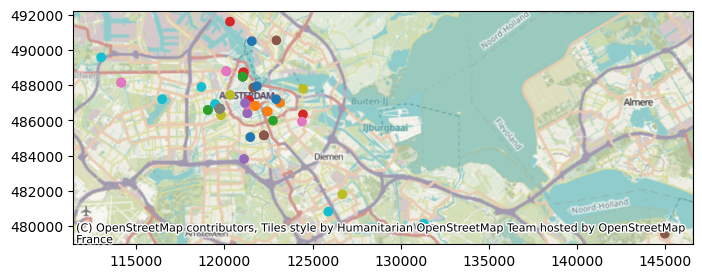

In [18]:
ax = gdf.plot(figsize=(8, 8), column = 'titel', legend = False)
cx.add_basemap(ax,crs=gdf.crs)

En een interactieve visualisatie kan ook (die is niet zichtbaar op de GitHub maar wel zelf te maken). Hierin kan de titel, omschrijving en datum van het evementent getoond worden wanneer men met de muis boven een puntje hovert:

In [21]:
gdf.explore(tooltip = ['titel','omschrijving','startdatum','einddatum'])